<a href="https://colab.research.google.com/github/rafaelrubo/python-geociencias/blob/main/python_geociencias09.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Python Aplicado às Geociências
##Parte 08
####Rafael Rubo
#####rafaelrubo@gmail.com

####Análise Automática de Dados Sísmicos
####Filtro passa-banda / Atributos instântaneos / Atributos geométricos / PCA / K-Means

In [1]:
!pip install segyio

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import segyio
from scipy.signal import butter, filtfilt, hilbert
from scipy.ndimage import gaussian_gradient_magnitude, laplace
from skimage.util import view_as_windows
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

In [3]:
# --- Função para criar e aplicar filtro ---
def butter_bandpass(lowcut, highcut, fs, order=4):
    nyq = 0.5 * fs  # frequência de Nyquist
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def apply_filter(data, lowcut, highcut, fs):
    b, a = butter_bandpass(lowcut, highcut, fs)
    return filtfilt(b, a, data, axis=0)  # aplica em cada traço (coluna)

In [4]:
# ---------- Leitura do SEGY ----------
segy_path = "seismic.sgy"
with segyio.open(segy_path, "r", ignore_geometry=True) as segy:
    n_traces = segy.tracecount
    samples = segy.samples[:]
    n_samples = len(samples)
    dt = ((samples[1] - samples[0])/1000) if n_samples > 1 else None # passo de amostragem em ms
    print(f"Traces: {n_traces}, Samples por trace: {n_samples}, dt = {dt}")
    data = np.stack([segy.trace[i] for i in range(n_traces)])

Traces: 444, Samples por trace: 1001, dt = 0.004


In [5]:
# --- Aplica filtro em todos os traços ---
fs = 1.0 / dt  # frequência de amostragem (Hz)
lowcut = 5.0   # Hz
highcut = 60.0 # Hz
seismic_filtered = apply_filter(data, lowcut, highcut, fs)

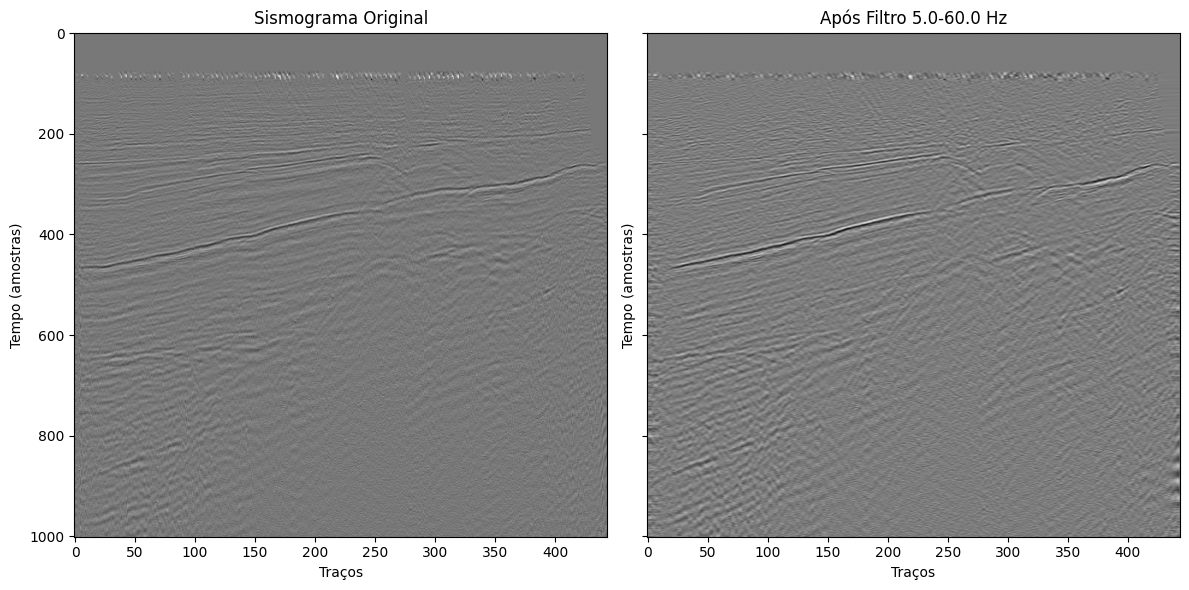

In [6]:
# --- Visualização ---
fig, axes = plt.subplots(1, 2, figsize=(12,6), sharey=True)

axes[0].imshow(data.T, cmap="gray", aspect="auto")
axes[0].set_title("Sismograma Original")

axes[1].imshow(seismic_filtered.T, cmap="gray", aspect="auto")
axes[1].set_title(f"Após Filtro {lowcut}-{highcut} Hz")

for ax in axes:
    ax.set_xlabel("Traços")
    ax.set_ylabel("Tempo (amostras)")

plt.tight_layout()
plt.show()

In [7]:
# --- Ajuste de dimensões ---
# Alguns arquivos SEGY podem vir como (1, n_traces, n_samples)
# ou (n_inlines, n_crosslines, n_samples)
seismic_filtered = np.squeeze(seismic_filtered)  # remove dimensões unitárias

if seismic_filtered.ndim == 1:
    # caso tenha apenas um traço
    data = seismic_filtered.reshape(-1, 1)
elif seismic_filtered.ndim == 2:
    # já é uma seção 2D (traço x amostras)
    data = seismic_filtered.T  # transpor para [tempo, traço]
elif data_raw.ndim == 3:
    # volume 3D, seleciona um inline
    data = seismic_filtered[0, :, :].T
else:
    raise ValueError("Formato de dado não reconhecido.")

In [8]:
# Corte das primeiras amostras - remoção da lamina dagua
# Supondo que "data" tem formato [tempo, traço]
data = data[100:, :]  # corta as 100 primeiras amostras

In [9]:
# --- Normalização ---
data = (data - np.mean(data)) / np.std(data)

In [10]:
# --- 1. Atributo: Amplitude Instantânea (Envelope Analítico) ---
analytic_signal = hilbert(data, axis=0)
amplitude_inst = np.abs(analytic_signal)

In [11]:
# --- 2. Atributo: Fase Instantânea ---
fase_inst = np.unwrap(np.angle(analytic_signal), axis=0)

In [12]:
# --- 3. Atributo: Frequência Instantânea ---
dt = 0.004  # Exemplo: 4 ms
freq_inst = np.abs(np.diff(fase_inst, axis=0) / (2 * np.pi * dt))
freq_inst = np.vstack([freq_inst, freq_inst[-1, :]])  # iguala tamanho

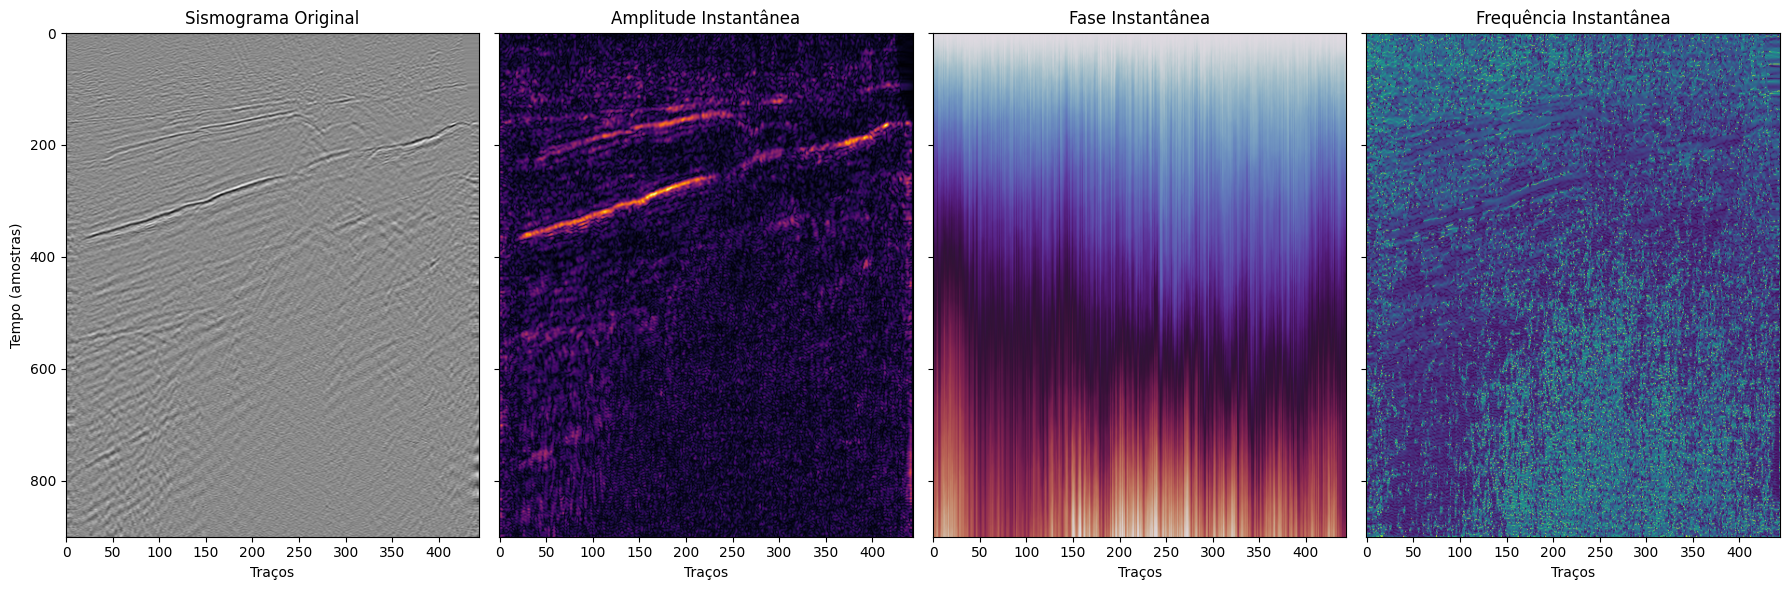

In [13]:
# --- Visualização dos Atributos ---
fig, axes = plt.subplots(1, 4, figsize=(18, 6), sharey=True)

axes[0].imshow(data, cmap='gray', aspect='auto')
axes[0].set_title("Sismograma Original")

axes[1].imshow(amplitude_inst, cmap='inferno', aspect='auto')
axes[1].set_title("Amplitude Instantânea")

axes[2].imshow(fase_inst, cmap='twilight', aspect='auto')
axes[2].set_title("Fase Instantânea")

axes[3].imshow(freq_inst, cmap='viridis', aspect='auto')
axes[3].set_title("Frequência Instantânea")

for ax in axes:
    ax.set_xlabel("Traços")
axes[0].set_ylabel("Tempo (amostras)")

plt.tight_layout()
plt.show()

In [14]:
# --- 1. Gradiente local (variação espacial) ---
gradiente = gaussian_gradient_magnitude(data, sigma=1)

In [15]:
# --- 2. Curvatura local (aproximada pelo Laplaciano) ---
curvatura = np.abs(laplace(data))

In [16]:
# --- 3. Semelhança (Coherence) simples via correlação local ---
def coherence_2d(section, window=5):
    """Calcula semelhança local média entre traços vizinhos"""
    pad = window // 2
    padded = np.pad(section, pad_width=pad, mode='reflect')
    coherence = np.zeros_like(section)
    for i in range(pad, pad + section.shape[0]):
        for j in range(pad, pad + section.shape[1]):
            bloco = padded[i-pad:i+pad+1, j-pad:j+pad+1]
            centro = bloco[pad, pad]
            var = np.mean((bloco - np.mean(bloco))**2)
            if var == 0:
                coherence[i-pad, j-pad] = 1
            else:
                corr = np.mean((bloco - np.mean(bloco)) * (centro - np.mean(bloco))) / var
                coherence[i-pad, j-pad] = np.clip(corr, 0, 1)
    return coherence

semelhanca = coherence_2d(data, window=5)

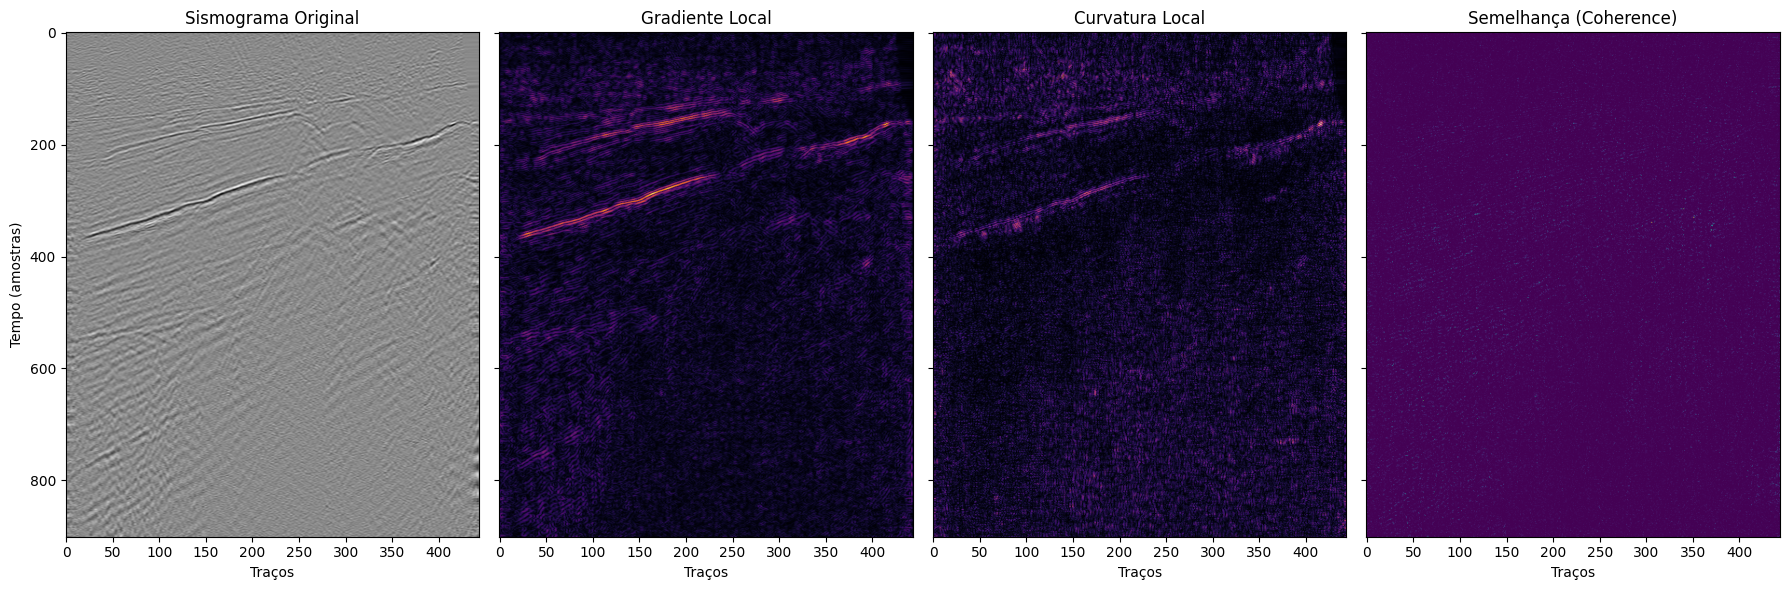

In [17]:
# --- Visualização ---
fig, axes = plt.subplots(1, 4, figsize=(18, 6), sharey=True)

axes[0].imshow(data, cmap='gray', aspect='auto')
axes[0].set_title("Sismograma Original")

axes[1].imshow(gradiente, cmap='inferno', aspect='auto')
axes[1].set_title("Gradiente Local")

axes[2].imshow(curvatura, cmap='magma', aspect='auto')
axes[2].set_title("Curvatura Local")

axes[3].imshow(semelhanca, cmap='viridis', aspect='auto')
axes[3].set_title("Semelhança (Coherence)")

for ax in axes:
    ax.set_xlabel("Traços")
axes[0].set_ylabel("Tempo (amostras)")

plt.tight_layout()
plt.show()

In [18]:
# Exemplo: seis atributos 2D (cada um [tempo, traço])
atributos = [amplitude_inst, fase_inst, freq_inst, semelhanca, curvatura, gradiente]

In [19]:
# Empilha e normaliza
X = np.stack(atributos, axis=-1)               # shape: (t, x, 6)
X_flat = X.reshape(-1, 6)
X_scaled = StandardScaler().fit_transform(X_flat)

In [20]:
# PCA
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_scaled)

In [21]:
# Reorganiza para o formato original
comp1, comp2, comp3 = X_pca[:,0], X_pca[:,1], X_pca[:,2]
comp1 = comp1.reshape(X.shape[:2])
comp2 = comp2.reshape(X.shape[:2])
comp3 = comp3.reshape(X.shape[:2])

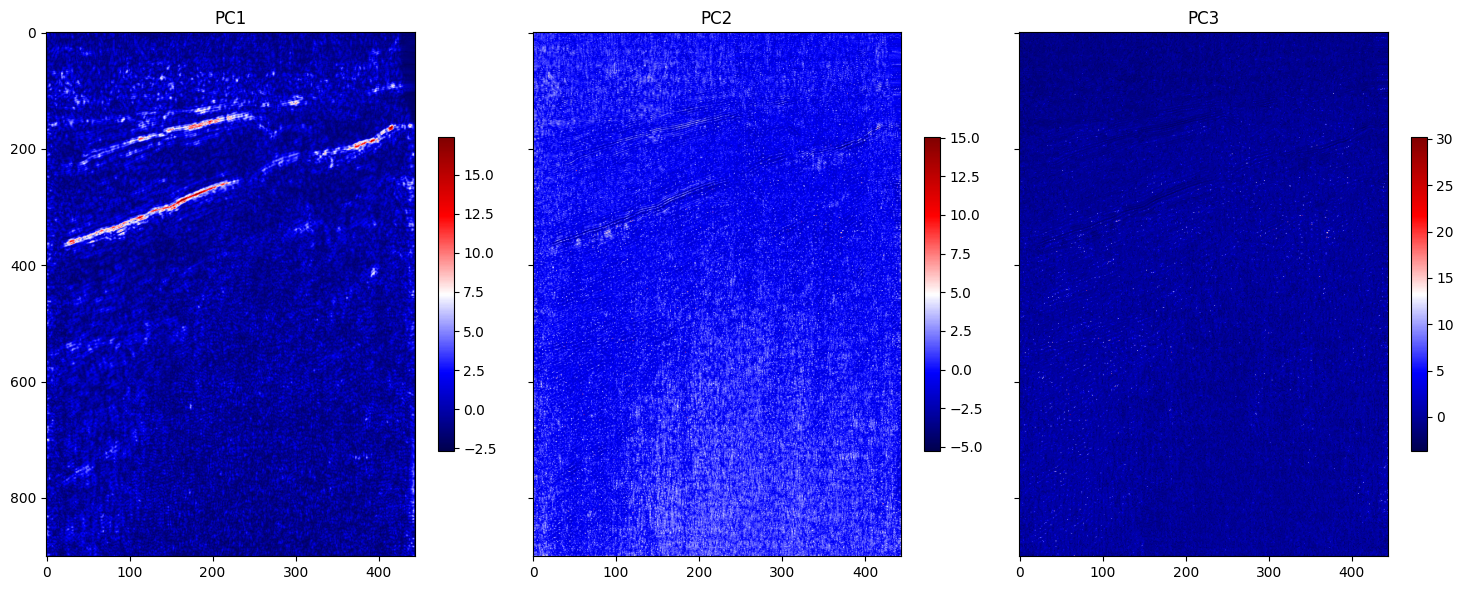

In [22]:
# Visualização
fig, axes = plt.subplots(1, 3, figsize=(15, 6), sharey=True)
for ax, comp, title in zip(axes, [comp1, comp2, comp3], ["PC1", "PC2", "PC3"]):
    im = ax.imshow(comp, cmap='seismic', aspect='auto')
    ax.set_title(title)
    plt.colorbar(im, ax=ax, shrink=0.6)
plt.tight_layout()
plt.show()

In [23]:
import plotly.express as px

# --- Visualização 3D ---
df_pca = {
    'PC1': X_pca[:, 0],
    'PC2': X_pca[:, 1],
    'PC3': X_pca[:, 2]
}
fig3d = px.scatter_3d(df_pca, x='PC1', y='PC2', z='PC3',
                      color=X_pca[:, 0], color_continuous_scale='Viridis',
                      title='Espaço dos Componentes Principais (PCA)')
fig3d.show()

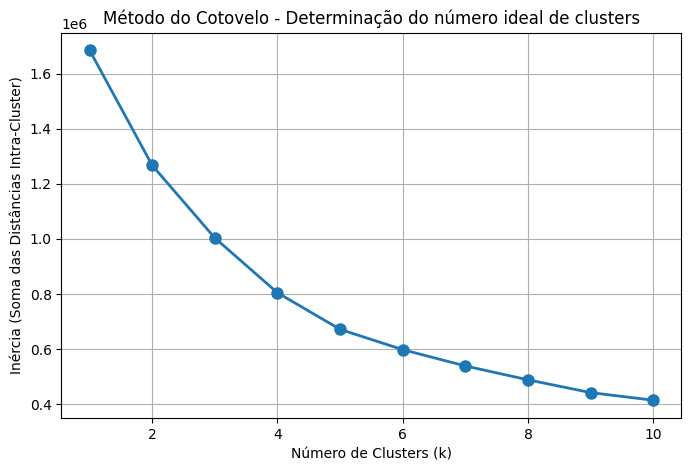

In [24]:
# --- Entrada: componentes principais do PCA ---
# comp1, comp2, comp3 → arrays 2D de mesmo tamanho
pca_stack = np.stack([comp1, comp2, comp3], axis=-1)  # shape (t, x, 3)
X_flat = pca_stack.reshape(-1, 3)

# --- Teste de diferentes números de clusters ---
inertias = []
K_values = range(1, 11)

for k in K_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=20)
    kmeans.fit(X_flat)
    inertias.append(kmeans.inertia_)  # Soma das distâncias intra-cluster

# --- Plot da Curva do Cotovelo ---
plt.figure(figsize=(8, 5))
plt.plot(K_values, inertias, 'o-', linewidth=2, markersize=8)
plt.title('Método do Cotovelo - Determinação do número ideal de clusters')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Inércia (Soma das Distâncias Intra-Cluster)')
plt.grid(True)
plt.show()

In [25]:
# --- K-means ---
n_clusters = 6  # número de classes desejado (ajuste conforme o caso)
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=20)
labels = kmeans.fit_predict(X_flat)

In [26]:
# --- Reorganiza para formato sísmico ---
clusters = labels.reshape(comp1.shape)

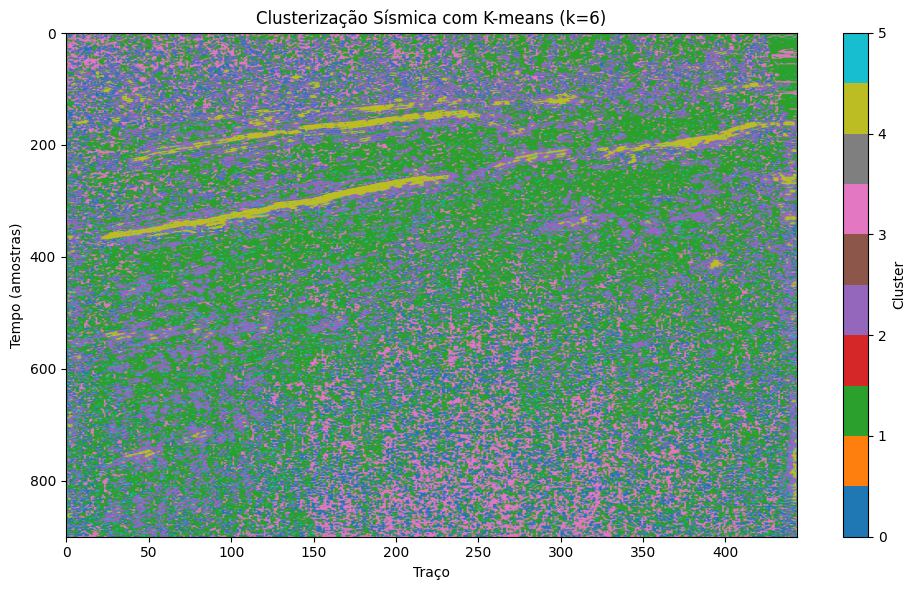

In [27]:
# --- Visualização 2D dos clusters ---
fig, ax = plt.subplots(figsize=(10, 6))
im = ax.imshow(clusters, cmap='tab10', aspect='auto')
plt.colorbar(im, ax=ax, label='Cluster')
ax.set_title(f"Clusterização Sísmica com K-means (k={n_clusters})")
plt.xlabel("Traço")
plt.ylabel("Tempo (amostras)")
plt.tight_layout()
plt.show()

In [28]:
# --- Visualização 3D no espaço dos componentes ---
df_clusters = {
    'PC1': X_flat[:, 0],
    'PC2': X_flat[:, 1],
    'PC3': X_flat[:, 2],
    'Cluster': labels
}

fig3d = px.scatter_3d(df_clusters, x='PC1', y='PC2', z='PC3',
                      color=df_clusters['Cluster'].astype(str),
                      color_discrete_sequence=px.colors.qualitative.Bold,
                      title='Clusterização no Espaço dos Componentes Principais')
fig3d.show()